<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture02/notebooks/L02_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

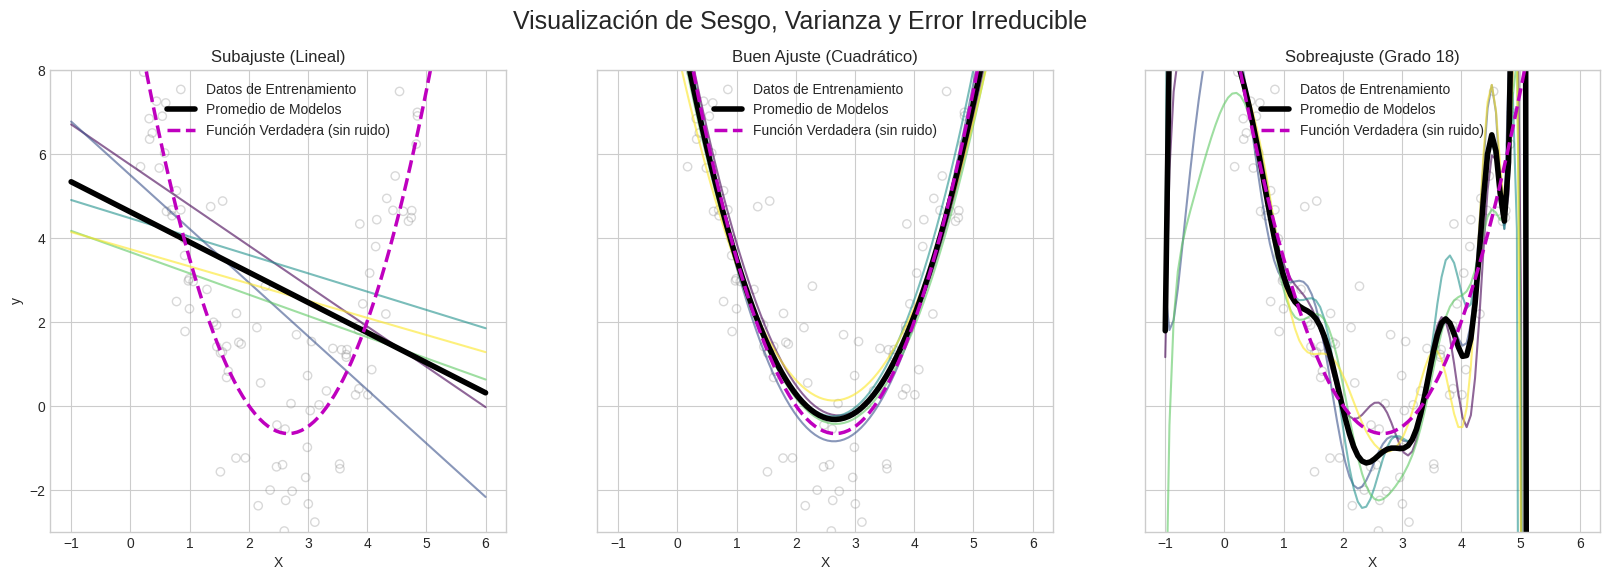

In [ ]:
# --- 1. Generar Datos desde una Función Cuadrática + Ruido ---
np.random.seed(42)
n_total_samples = 100
X_pool = np.sort(np.random.rand(n_total_samples) * 5) # El rango de X

# La función verdadera (sin ruido)
def true_fn(x):
    return 1.5 * x**2 - 8 * x + 10

# Añadir ruido gaussiano para crear los datos de entrenamiento
y_pool = true_fn(X_pool) + np.random.randn(n_total_samples) * 1.5

# Reshape para que sea compatible con Scikit-learn
X_pool = X_pool[:, np.newaxis]

# --- 2. Preparar el Lienzo para las Gráficas ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Visualización de Sesgo, Varianza y Error Irreducible', fontsize=18)

# Datos de prueba para dibujar las curvas de los modelos
X_test = np.linspace(-1, 6, 100)[:, np.newaxis]

# --- 3. Definir Modelos y Entrenar 5 Veces ---
n_entrenamientos = 5
colores = plt.cm.viridis(np.linspace(0, 1, n_entrenamientos))

degrees = [1, 2, 18]
titles = ['Subajuste (Lineal)', 'Buen Ajuste (Cuadrático)', 'Sobreajuste (Grado 18)']

for i, ax in enumerate(axs):
    degree = degrees[i]

    # Graficar los datos originales de fondo
    ax.scatter(X_pool, y_pool, facecolors='none', edgecolors='gray', alpha=0.3, label='Datos de Entrenamiento')

    all_predictions = []

    for j in range(n_entrenamientos):
        # Tomar una muestra aleatoria para este entrenamiento
        indices = np.random.choice(range(n_total_samples), size=40, replace=False)
        X_train_sample, y_train_sample = X_pool[indices], y_pool[indices]

        # Crear y entrenar el modelo
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(X_train_sample, y_train_sample)

        # Predecir y graficar la curva resultante
        y_plot = model.predict(X_test)
        all_predictions.append(y_plot)
        ax.plot(X_test, y_plot, color=colores[j], linewidth=1.5, alpha=0.6)

    # Calcular y graficar el promedio de los modelos
    mean_prediction = np.mean(all_predictions, axis=0)
    ax.plot(X_test, mean_prediction, color='black', linewidth=4, label='Promedio de Modelos')

    # --- NOVEDAD: Graficar la función verdadera sin ruido ---
    ax.plot(X_test, true_fn(X_test), 'm--', linewidth=2.5, label='Función Verdadera (sin ruido)')

    ax.set_title(titles[i])
    ax.set_ylim(-3, 8)
    ax.set_xlabel('X')
    ax.legend()

axs[0].set_ylabel('y')

plt.show()

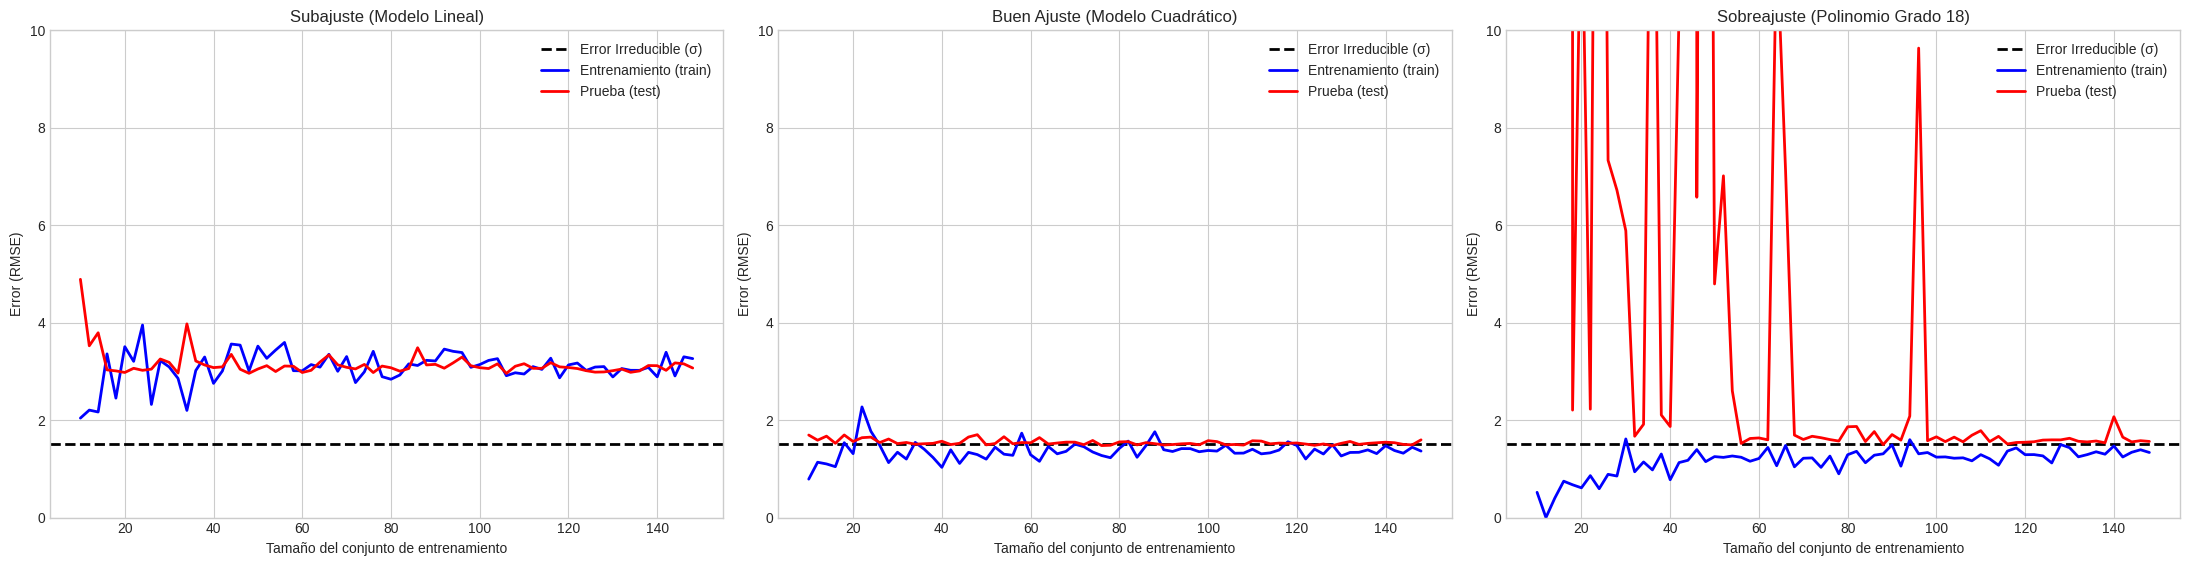

In [ ]:
# --- 1. Generar el conjunto de datos completo ---
np.random.seed(42)
n_samples = 200 # Aumentamos un poco para tener más datos para muestrear
X = np.sort(np.random.rand(n_samples) * 5)

noise_level_sigma = 1.5
y = 1.5 * X**2 - 8 * X + 10 + np.random.randn(n_samples) * noise_level_sigma

X = X[:, np.newaxis]

# Dividimos una sola vez en un gran conjunto de entrenamiento y uno de prueba
X_train_pool, X_test, y_train_pool, y_test = train_test_split(X, y, test_size=50, random_state=42)

# --- 2. Función para graficar con muestreo aleatorio ---
def plot_learning_curves_random_sampling(model, ax, title):
    train_errors, test_errors = [], []
    training_set_sizes = range(10, len(X_train_pool), 2)

    for m in training_set_sizes:
        # --- NOVEDAD: Tomar una muestra aleatoria de tamaño 'm' en cada iteración ---
        # En lugar de X_train_pool[:m], seleccionamos 'm' índices al azar
        random_indices = np.random.choice(len(X_train_pool), m)
        X_train_sample = X_train_pool[random_indices]
        y_train_sample = y_train_pool[random_indices]

        # Entrenar el modelo con la muestra aleatoria
        model.fit(X_train_sample, y_train_sample)

        # Calcular error en esa misma muestra de entrenamiento
        y_train_predict = model.predict(X_train_sample)
        train_errors.append(mean_squared_error(y_train_sample, y_train_predict))

        # Calcular error en el conjunto de prueba FIJO
        y_test_predict = model.predict(X_test)
        test_errors.append(mean_squared_error(y_test, y_test_predict))

    # Graficar
    ax.axhline(y=noise_level_sigma, color='black', linestyle='--', linewidth=2, label='Error Irreducible (σ)')
    ax.plot(training_set_sizes, np.sqrt(train_errors), "b-", linewidth=2, label="Entrenamiento (train)")
    ax.plot(training_set_sizes, np.sqrt(test_errors), "r-", linewidth=2, label="Prueba (test)")
    ax.set_title(title)
    ax.set_xlabel("Tamaño del conjunto de entrenamiento")
    ax.set_ylabel("Error (RMSE)")
    ax.legend()
    ax.set_ylim(0, 10)

# --- 3. Definir modelos y graficar ---
fig, axs = plt.subplots(1, 3, figsize=(22, 6))

# Modelo 1: Lineal (Subajuste)
linear_model = LinearRegression()
plot_learning_curves_random_sampling(linear_model, axs[0], "Subajuste (Modelo Lineal)")

# Modelo 2: Cuadrático (Buen Ajuste)
quadratic_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
plot_learning_curves_random_sampling(quadratic_model, axs[1], "Buen Ajuste (Modelo Cuadrático)")

# Modelo 3: Grado Alto (Sobreajuste)
overfit_model = make_pipeline(PolynomialFeatures(degree=18, include_bias=False), LinearRegression())
plot_learning_curves_random_sampling(overfit_model, axs[2], "Sobreajuste (Polinomio Grado 18)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

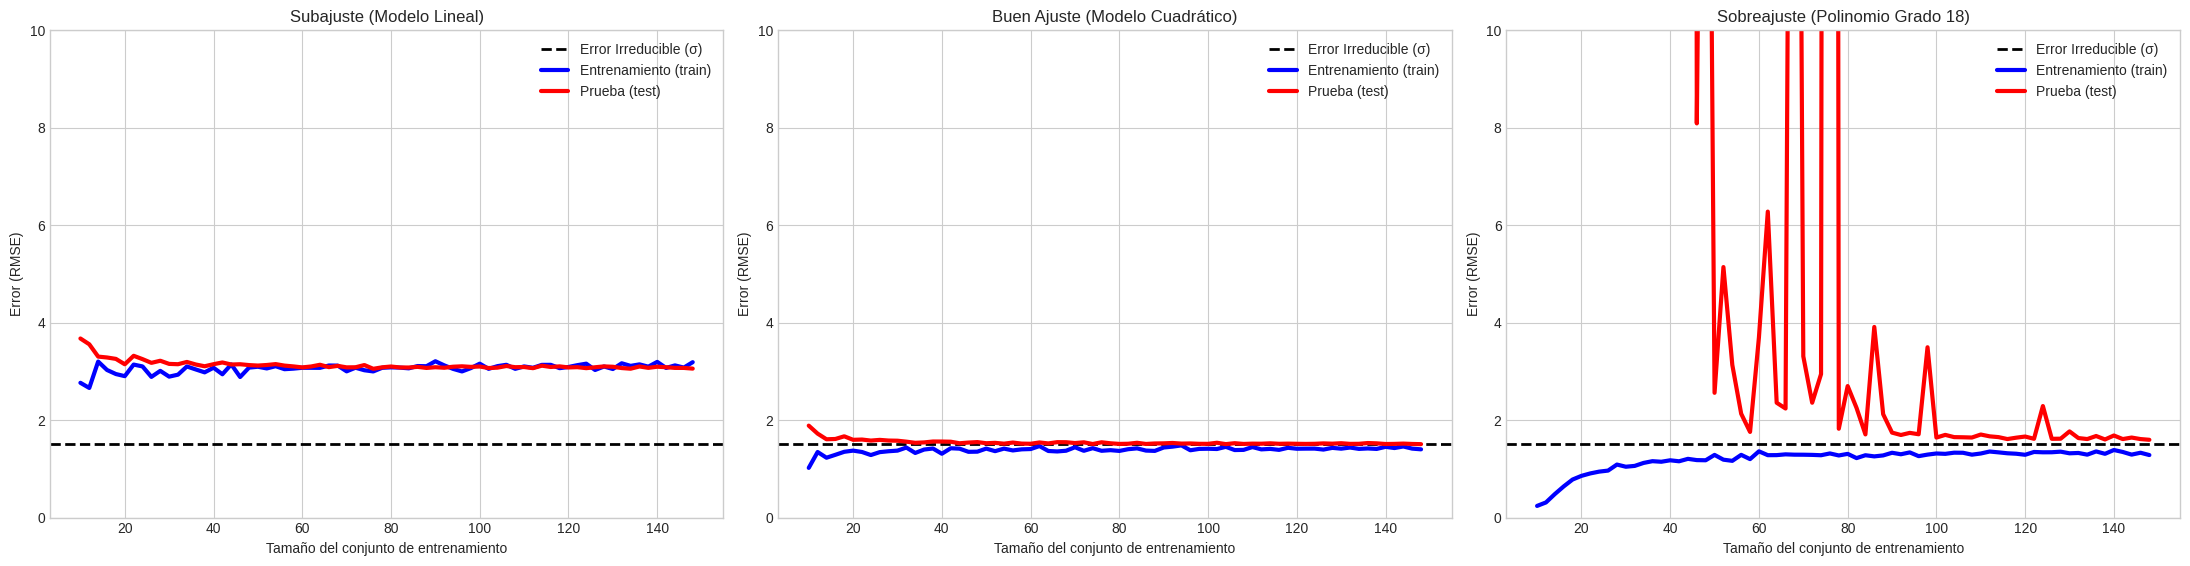

In [ ]:
# --- 1. Generar el conjunto de datos completo ---
np.random.seed(42)
n_samples = 200
X = np.sort(np.random.rand(n_samples) * 5)

noise_level_sigma = 1.5
y = 1.5 * X**2 - 8 * X + 10 + np.random.randn(n_samples) * noise_level_sigma

X = X[:, np.newaxis]

# Dividir una sola vez en un gran conjunto de entrenamiento y uno de prueba
X_train_pool, X_test, y_train_pool, y_test = train_test_split(X, y, test_size=50, random_state=42)

# --- 2. Función para graficar con promedios de múltiples experimentos ---
def plot_smooth_learning_curves(model, ax, title, n_runs=20):
    """
    Calcula y grafica curvas de aprendizaje promediando sobre n_runs para suavizar.
    """
    training_set_sizes = range(10, len(X_train_pool), 2)

    # Almacenar los errores de cada corrida
    train_errors_runs = np.zeros((len(training_set_sizes), n_runs))
    test_errors_runs = np.zeros((len(training_set_sizes), n_runs))

    for i, m in enumerate(training_set_sizes):
        for run in range(n_runs):
            # Tomar una muestra aleatoria
            random_indices = np.random.choice(len(X_train_pool), m)
            X_train_sample, y_train_sample = X_train_pool[random_indices], y_train_pool[random_indices]

            # Entrenar el modelo
            model.fit(X_train_sample, y_train_sample)

            # Calcular y guardar errores
            train_errors_runs[i, run] = mean_squared_error(y_train_sample, model.predict(X_train_sample))
            test_errors_runs[i, run] = mean_squared_error(y_test, model.predict(X_test))

    # Calcular el promedio de los errores de todas las corridas
    mean_train_errors = np.sqrt(np.mean(train_errors_runs, axis=1))
    mean_test_errors = np.sqrt(np.mean(test_errors_runs, axis=1))

    # Graficar las curvas promedio
    ax.axhline(y=noise_level_sigma, color='black', linestyle='--', linewidth=2, label='Error Irreducible (σ)')
    ax.plot(training_set_sizes, mean_train_errors, "b-", linewidth=3, label="Entrenamiento (train)")
    ax.plot(training_set_sizes, mean_test_errors, "r-", linewidth=3, label="Prueba (test)")
    ax.set_title(title)
    ax.set_xlabel("Tamaño del conjunto de entrenamiento")
    ax.set_ylabel("Error (RMSE)")
    ax.legend()
    ax.set_ylim(0, 10)

# --- 3. Definir modelos y graficar ---
fig, axs = plt.subplots(1, 3, figsize=(22, 6))

# Modelo 1: Lineal (Subajuste)
linear_model = LinearRegression()
plot_smooth_learning_curves(linear_model, axs[0], "Subajuste (Modelo Lineal)")

# Modelo 2: Cuadrático (Buen Ajuste)
quadratic_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
plot_smooth_learning_curves(quadratic_model, axs[1], "Buen Ajuste (Modelo Cuadrático)")

# Modelo 3: Grado Alto (Sobreajuste)
overfit_model = make_pipeline(PolynomialFeatures(degree=18, include_bias=False), LinearRegression())
plot_smooth_learning_curves(overfit_model, axs[2], "Sobreajuste (Polinomio Grado 18)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()